<a href="https://colab.research.google.com/github/DivyaSwamy/Channel-Dynamics/blob/master/brest_cancer_classification_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Author - Divya Swaminathan

#### Sept 2025

#### <u>Goals</u>

1) Load the breast cancer demo set from Huggingface.
2) Work on image classification with the google viT model. This is the default image classification model in transformers library.
3) Evaluate classification model.
4) Retrain, classificationl layer, if necessary.
5) Due to rendering issues from Colab to github - all outputs have been cleared. It should run smoothly in google colab.
   
#### <u> Outcomes & Learnings </u>

1) First the dataset has to be trimmed. As original demo dataset has 7500 training images -  (7500/batch size 16)*4 epochs --> training time of 5hrs -> overkill for the task at hand (see Notes), a subset of images will suffice.
2) A model trained on general images will not work for our breast cancer dataset. Hence, classification layer needs to be retrained.
3) Pretty good performance, for this dataset, is achieved with our retrained model.


#### <u> Notes </u>

1) In this dataset there are two categories, benign and malignant. In my opinion, just looking at the images, this classification is not a complex task for heavy weight network models. Small number of images and training epochs give us good accuracy.
2) The breast cancer demo dataset is a subset of the *"Aliounethegoat/classification-medicale-multi-cancer"* dataset - a dataset that contains images from several different cancer types.
3) You can find how I created this demo dataset in *create_demo_dataset.ipynb*

In [ ]:
!pip install --quiet evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import io
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [ ]:
from huggingface_hub import login
from google.colab import userdata

HF_TOKEN = userdata.get('huggingface_token') # Retrieve the token from secrets

if HF_TOKEN:
  login(HF_TOKEN)
  print("Successfully logged in to Hugging Face!")
else:
  print("Hugging Face token not found in Colab Secrets.")

Successfully logged in to Hugging Face!


In [ ]:
path_to_dataset = "divyaswamy/breast_cancer_practice"

In [ ]:
ds = load_dataset(path_to_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/670 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1250 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 7500
    })
    validation: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 1250
    })
    test: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 1250
    })
})

#### Generate a subset of dataset to ease training.



*   Make sure number of images in subset are a muliple of 16, i.e. batch size.
*  I need it to be a more managable size for training hence reducing the size of the dataset.



In [ ]:

ds['train'] = ds['train'].shuffle().select(np.arange(16*62))
ds['test'] = ds['test'].shuffle().select(np.arange(16*20))
ds['validation'] = ds['validation'].shuffle().select(np.arange(16*20))


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 992
    })
    validation: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 320
    })
    test: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 320
    })
})

#### Basic exploration of dataset



*   Check if dataset is balanced or not?
*   Randomly plot a set of images.



In [ ]:
from collections import defaultdict

def count_label(dataset):
  """
  Function counts the distribution of 'label's in a dataset.
  """
  counts = defaultdict(int)
  for label in dataset['label']:
    counts[label] += 1
  return counts


def show_samples(dataset, nrows = 2, ncols = 2):
  """
  Function plots a random selection of images from dataset.
  """
  samples = dataset.shuffle().select(np.arange(nrows*ncols))
  fig = plt.figure(figsize = (4*ncols, 4*nrows))
  #
  for i in range(nrows*ncols):
      img = np.array(samples[i]['image'])
      label = samples[i]['label']
      fig.add_subplot(nrows,ncols,i+1)
      plt.imshow(img)
      plt.title(label)
      plt.axis('off')


In [ ]:
for idx in ['train', 'test', 'validation']:
  print(idx, count_label(ds[idx]))

train defaultdict(<class 'int'>, {'breast_malignant': 489, 'breast_benign': 503})
test defaultdict(<class 'int'>, {'breast_malignant': 155, 'breast_benign': 165})
validation defaultdict(<class 'int'>, {'breast_malignant': 169, 'breast_benign': 151})


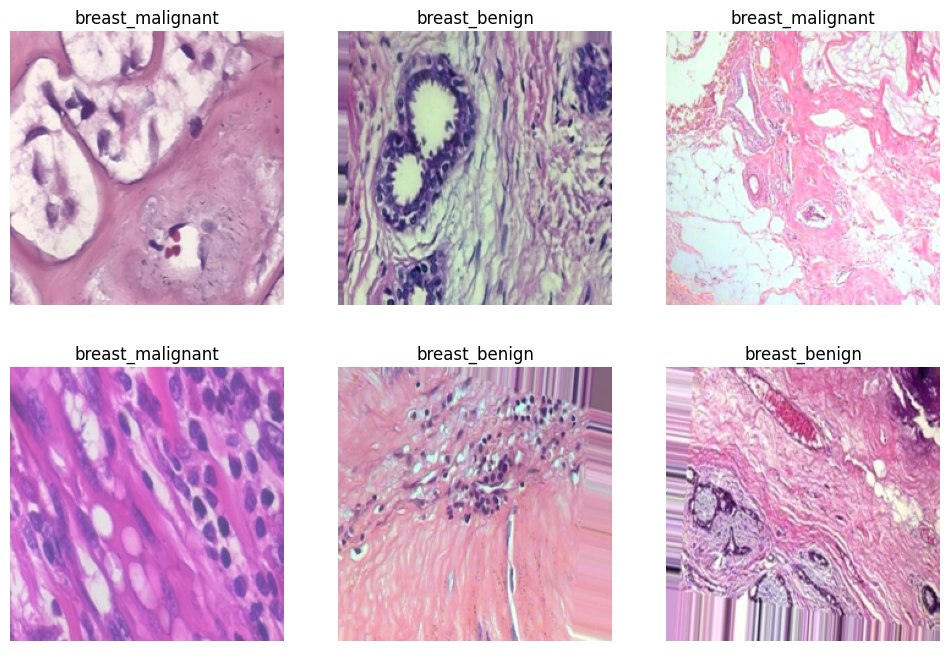

In [ ]:
show_samples(ds['test'], 2, 3)

#### Pre trained models won't work for our cancer dataset as is.

* Test the default vision model for classification in huggingface - ''google/vit-base-patch16-224'

*  Test with - 'facebook/dinov2-small-imagenet1k-1-layer'


In [ ]:
from transformers import pipeline

classifier = pipeline('image-classification',
                      model='google/vit-base-patch16-224')
 # will work if you don't specify the model

result = classifier(ds['test'][0]['image'])

print('Image is classified as:-', result[0]['label'],
      'with a probability score of', result[0]['score'])

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


Image is classified as:- nematode, nematode worm, roundworm with a probability score of 0.15509609878063202


In [ ]:
classifier = pipeline('image-classification',
                      model='facebook/dinov2-small-imagenet1k-1-layer')

result = classifier(ds['test'][0]['image'])

print('Image is classified as:-', result[0]['label'],
      'with a probability score of', result[0]['score'])

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/91.3M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Image is classified as:- nematode, nematode worm, roundworm with a probability score of 0.22484757006168365


#### Generate mappings for dataset

In [ ]:
labels = ds['train'].unique('label')

label2id = {label:idx for idx, label in enumerate(labels)}
id2label = {idx:label for idx, label in enumerate(labels)}

print(label2id)
print(id2label)

Flattening the indices:   0%|          | 0/992 [00:00<?, ? examples/s]

{'breast_malignant': 0, 'breast_benign': 1}
{0: 'breast_malignant', 1: 'breast_benign'}


#### Preprocess images as per model of choice using AutoImageProcessor

* processor can work on 1 image, a section of the dataset or transform the whole dataset

In [ ]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def transform_images(batch):
  """
  Function reformats images based on AutoImageProcessor and converts labels to ids.
  """
  inputs = processor(batch['image'],return_tensors='pt')
  inputs['labels']=[label2id[y] for y in batch['label']]

  return inputs

In [ ]:
#processed_dataset = ds.with_transform(transform_images)

In [ ]:
#io.BytesIO(ds['test'][0]['image'])

x = processor(ds['test'][0:20]['image'], return_tensors='pt')
print(x['pixel_values'].shape)
print('The pixel values have been reformatted based on AutoImageProcessor. Just see how a single pixel value changes')
print(x['pixel_values'][10][1,1,1])
print(np.array(ds['test'][10]['image'])[1,1,1])


torch.Size([20, 3, 224, 224])
The pixel values have been reformatted based on AutoImageProcessor. Just see how a single pixel value changes
tensor(0.0745)
137


In [ ]:
processed_ds = ds.with_transform(transform_images)


In [ ]:
processed_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 992
    })
    validation: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 320
    })
    test: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 320
    })
})

The following bit of code shows how ***processed_ds*** compares with ***ds***.


In [ ]:
print(processed_ds['train'][0]['pixel_values'].shape)
print(processed_ds['train'][0]['pixel_values'][1,1,1])
print(np.array(ds['train'][0]['image'])[1,1,1])

torch.Size([3, 224, 224])
tensor(0.2000)
153


In [ ]:
def collate_fn(batch):
  """
  Function to ...
  """
  return {
      'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      'labels': torch.tensor([x['labels'] for x in batch])
  }

#### Define how metrics will be calculated.

Using Hugging Face `evaluate` library to calculate the metrics. For image classification, use the 'accuracy' metric.

In machine learning, logits are the raw, unnormalized predictions produced by a model's final layer before applying an activation function like sigmoid or softmax. These scores represent the model's initial confidence or scores for different classes but are not yet probabilities. Logits are then transformed into interpretable probabilities, which are used for decision-making in classification tasks

In [ ]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

#### Load the model

In [ ]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True
)

In [ ]:
# p are the number of weights for every layer
# since one would only like to train the classifier layer -
# we need to tell the program to freeze all weights (p's) except the final classifier
# layer
#
for name, p in model.named_parameters():
  print(name,'outputs per layer:-',  p.numel())

for name,p in model.named_parameters():
  if not name.startswith('classifier'):
    p.requires_grad = False

#### Commence training

Things to remember  -


*   output_dir should be listed. This is the name of the model you will call in the classifier pipeline for inference purposes.
*   I have set push_to_hub as TRUE. Unless I actually execute the command the trained model will not showup in my huggingface profile.



In [ ]:
training_args = TrainingArguments(
    output_dir="test_bc_model", # this is important.
    per_device_train_batch_size=16,
    save_strategy ="epoch",
    eval_strategy="epoch",
    logging_steps = 50,
    learning_rate=5e-4,
    num_train_epochs=3,
    save_total_limit=2,
    remove_unused_columns = False,
    push_to_hub = True,
    report_to = 'tensorboard',
    load_best_model_at_end=True

)

In [ ]:
model_trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    train_dataset = processed_ds['train'],
    eval_dataset = processed_ds['validation'],
    tokenizer = processor
)

Time to train 4 epochs - 34m, logging steps = 500

|Epoch|	Training Loss	|Validation Loss	|Accuracy|
|----|----|----|----|
1	|No log|	0.192261|	0.962500
2	|No log	|0.131176	|0.975000
3	|No log	|0.113285	|0.975000
4	|No log	|0.103966	|0.971875

Reduces logging steps and epochs to 3 and trained again


In [ ]:
model_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.071459,0.981250
2,No log,0.064375,0.987500
3,No log,0.061689,0.984375


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=186, training_loss=0.04645099434801327, metrics={'train_runtime': 2367.2733, 'train_samples_per_second': 1.257, 'train_steps_per_second': 0.079, 'total_flos': 2.752515471110308e+17, 'train_loss': 0.04645099434801327, 'epoch': 3.0})

#### Test fine tuned (trained) model on a test image

* Even though the probability score may be low < 90% the classification is accurate when you run through the ***ds['test']*** set

In [ ]:
classifier = pipeline('image-classification', model='test_bc_model')

idx = 100

result = classifier(ds['test'][idx]['image'])

print('Image is classified as:-', result[0]['label'],
      'with a probability score of', result[0]['score'])
print('original label is' , ds['test'][idx]['label'])

Device set to use cpu


Image is classified as:- breast_malignant with a probability score of 0.9957194924354553
original label is breast_malignant


In [ ]:
for i in range(20, 300):
  result = classifier(ds['test'][i]['image'])
  # print('Image is classified as:-', result[0]['label'],
  #       'with a probability score of', result[0]['score'])
  # print('original label is' , ds['test'][i]['label'])
  if result[0]['label'] != ds['test'][i]['label']:
    print(i, result[0]['label'], ds['test'][i]['label'], round(result[0]['score'], 5))

149 breast_malignant breast_benign 0.75759
170 breast_malignant breast_benign 0.71507
249 breast_malignant breast_benign 0.7688


#### How to test this on the processed_ds dataset?

In [ ]:
from torchvision import transforms

def convert_to_pil(tensor):
  '''
  Function that takes in an image tensor and converts input to PIL image.
  '''
  pil_image = transforms.ToPILImage()
  return pil_image(tensor)

In [ ]:
idx = 200

pil_image = convert_to_pil(processed_ds['test'][idx]['pixel_values'])

result = classifier(pil_image)

print('Image is classified as:-', result[0]['label'],
      'with a probability score of', result[0]['score'])
print('original label is' , processed_ds['test'][idx]['labels'])
print(label2id)

Image is classified as:- breast_benign with a probability score of 0.8237860798835754
original label is 0
{'breast_malignant': 0, 'breast_benign': 1}
